# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [16]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


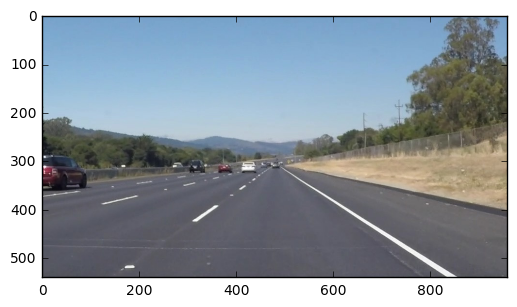

In [17]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [18]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
 
    # for each line compute: slope, low point, high point
    # collect in 2 baskets by slope value 
    #    one basket should have positive slopes (i.e. right lane), one negative slopes (left lane)
    neg_slopes = list()
    pos_slopes = list()
    for line in lines:
        for x1,y1,x2,y2 in line:
            # compuet slope
            if x1 != x2:
                slope = (y2 - y1) / (x2- x1)
            elif y2 > y1:
                slope = 999999  # dummy for pos infinity
            elif y2 < y1:
                slope = -999999 # dummy for neg infinity
            else:
                continue
            if slope >= 0:
                if x1 <= x2: # in this case (x1,y1) is the lower point
                    pos_slopes.append((slope, (x1, y1), (x2, y2)))
                else:
                    pos_slopes.append((slope, (x2, y2), (x1, y1)))
            else:
                if x1 <= x2: # in this case (x2, y2) is the lower point
                    neg_slopes.append((slope, (x2, y2), (x1, y1)))
                else:
                    neg_slopes.append((slope, (x1, y1), (x2, y2)))

    # draw lines for each basket
    right_lane = compute_lane(pos_slopes, img)
    if right_lane:
        cv2.line(img, right_lane[0], right_lane[1], color, thickness)
    left_lane = compute_lane(neg_slopes, img)
    if left_lane:
        cv2.line(img, left_lane[0], left_lane[1], color, thickness)

def compute_lane(slope_tuples, img):
    # get avg slope
    dirty_mean_slope = np.mean([t[0] for t in slope_tuples])
    dirty_mean_std = np.std([t[0] for t in slope_tuples])
    
    # clean 'bad' line segments
    clean_slopes = [t for t in slope_tuples if np.abs(t[0] - dirty_mean_slope) <= dirty_mean_std * 2]
    
    if not clean_slopes:
        return None
    
    # compute low point and high point
    x_low, y_low, x_high, y_high = None, None, None, None
    for _, (x, y), (a, b) in clean_slopes:
        if y_low == None or y < y_low:
            y_low = y
            x_low = x
        if y_high == None or b > y_high:
            y_high = b
            x_high = a
    
    # if y_high is not max, extend the line
    clean_mean = np.mean([t[0] for t in clean_slopes])
    imshape = img.shape
    if y_high < imshape[1] and np.abs(clean_mean) > 0.01:
        x_high = int((imshape[1] - y_high) / clean_mean + x_high)
        y_high = imshape[1]
        
    return (x_low, y_low), (x_high, y_high)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Define a function to mark lines in one image

We first define a function that takes as input one image and returns an image with marked lines

In [19]:
def mark_lines_in_image(img,
                        kernel_size=5,
                        low_threshold=50,
                        high_threshold=150,
                        rho=2,
                        theta=np.pi/180,
                        threshold=15,
                        min_line_len=40,
                        max_line_gap=20,
                       ):
    """
    Function to mark lines in one image.
    
    'img' is image read by e.g. matplotlib.image.mpimg
    kernel_size: kernel size for Guassian blur
    low_threshold, high_threshold: Canny parameters
    rho, theta, threshold, min_line_len, max_line_gap: Hough parameters
    """
    mod_img = (img*255).astype('uint8')
    
    # convert to gray scale
    gray = grayscale(mod_img)
    #plt.imshow(gray, cmap='gray')
    
    # apply Gaussian blur
    blur_gray = gaussian_blur(gray, kernel_size)
    #plt.imshow(blur_gray, cmap='gray')
    
    # search edges using Canny algo
    edges = canny(blur_gray, low_threshold, high_threshold)
    #plt.imshow(edges, cmap='gray')
    
    # define vertices for region of interest
    imshape = img.shape
    vertices = np.array([
        [
            (0, imshape[0]),                                               # lower left corner
            (imshape[1]/2 - imshape[0]/10, imshape[0]/2 + imshape[1]/16),  # slightly left and down of inage midpoint
            (imshape[1]/2 + imshape[0]/10, imshape[0]/2 + imshape[1]/16),  # slightly right and down of image midpoint
            (imshape[1], imshape[0])                                       # lower right corner of image
        ]
    ], dtype=np.int32)
    
    # cut out region of interest
    masked_edges = region_of_interest(edges, vertices)
    #plt.imshow(masked_edges, cmap='gray')
    
    # apply Hough transform
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    #plt.imshow(line_img, cmap='gray')
    
    # Draw the lines on the edge image
    lines_edges = weighted_img(line_img, img)
    #plt.imshow(lines_edges)

    return lines_edges

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [20]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteCurve.jpgmod.png',
 'solidWhiteRight.jpg',
 'solidWhiteRight.jpgmod.png',
 'solidYellowCurve.jpg',
 'solidYellowCurve.jpgmod.png',
 'solidYellowCurve2.jpg',
 'solidYellowCurve2.jpgmod.png',
 'solidYellowLeft.jpg',
 'solidYellowLeft.jpgmod.png',
 'whiteCarLaneSwitch.jpg',
 'whiteCarLaneSwitch.jpgmod.png']

run your solution on all test_images and make copies into the test_images directory).

### Test function on one image

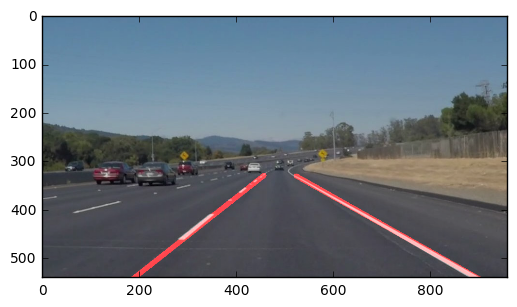

In [21]:
new_img = mark_lines_in_image(mpimg.imread('test_images/solidWhiteCurve.jpg'))
plt.imshow(new_img)

### Test function on all images

In [22]:
import glob
img_dir = "test_images"
for test_image in glob.glob(os.path.join(img_dir, '*.jpg')):
    new_file = test_image + 'mod.png'
    new_img = mark_lines_in_image( mpimg.imread(test_image) )
    mpimg.imsave(new_file, new_img)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [24]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image with lines are drawn on lanes)
    result = mark_lines_in_image( image )
    return result

Let's try the one with the solid white lane on the right first ...

In [10]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 221/222 [00:06<00:00, 34.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 7.42 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [12]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 681/682 [00:21<00:00, 30.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 22.5 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## My Reflections on the project

Most of the problem could be solved by using the lecture material.  The only really new part was drawing the complete lines instead of just the segments.  

The pipeline works as follows:
  - We start with an image and convert it to grayscale.
  - Then we apply a 'Guassian smoothing' to get rid of small artefacts that could confuse the edge detection algorithm.
  - After the smoothing we run the Canny algorith to detect the locations with the largest gradiants.
  - We then limit the region we are interested in.  E.g. we would never expect lane lines above the horizon.
  - The result of the Canny algorithm are individual locations with strong gradiants.  We now have to find which individual locations actually make up line segments.  This is done using the Hough transform.
  - Within the "Hough lines" step we also have to decide which line segments make up the full lane lines we are interested in.  Here, I used the following strategy:
      * I first sort all line segments into 2 buckets.  One with negative slopes and one with positive slopes.
      * In each bucket I apply some "cleaning", i.e. I throw out the line segments which have slopes which dramatically differ from the mean slope of that bucket.
      * Then I take the mean od the cleaned slopes as my final slope and I compute the beginning on the end point of the final lane line.
      
The approach above works quite well on the easy examples.  Running it on the challenge causes some troubles though.  I see that strong curves, shadows and other white objects confuse the algorithm occasionally.

### Possible improvements
  * Overall the code could be more robust.  We have to cleanly handle dirty input in various places such that even difficult input situation (shadows on the raod, curves, white carse switching lanes, etc.) don't lead to code crashes, or bizarre output lines.
  * I don't like how the drawn lines "jitter" in the video.  I think it would be possible to stabilize this by passing the slopes of the last image to the computations for the next image.  That latter computation could then respect the last results and only slightly adjust.  Alternatively you could draw in each frame an "average" of the last 10 frames (not sure if 10 is a good number).  This should result in a way more smooth video.
  * The current output is binary, i.e. we draw two lanes regardless of how certain we are about their positions.  If following processes depend on the output of the lane recognition it would be useful to include a measure of confidence in the output.
  * There are many parameters going into the recognition pipeline.   In the solution above, I chose those parameters by playing around with them a bit and eye-balling the output.  To improve the algorithm we should carefully study the effect of changing them.  We should come up with a metric on how good a recognition output is such that we don't only rely on our visual assesment of how well a line fits.
  * For choosing the best parameters and in general for improving the algorithm it would be great to have (a lot) more training data.  The best would be training data including manually marked lane lines such that we can compare the algorithms output against a "gold standard".
  * I expect that in improving the pipeline we will have to balance accuracy and computational resources.  We can surely improve the accuracy of the recognition by including more sanity checks and by choosing parameters which improve the accuracy of the involved individual steps.  However each of such improvements could imply using more computational time and/or more memory.  Finding a good balance between accuracy and resource usage will be a crucial part in the final implementation.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [14]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:16<00:00, 14.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 19.6 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))